In [1]:
import numpy as np
import xarray as xr
import sys
import glob
import netCDF4 as nc
import os
import sys
import h5py
import scipy.io
from scipy.interpolate import griddata
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
import cartopy.feature as cfeature
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as colors
import pandas
from datetime import timedelta
from datetime import date


from os.path import join,expanduser,exists,split
user_home_dir = expanduser('~')
sys.path.append(join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

from functions_ecco_NEW import shift_longitude, remove_text_after_second_underscore, calculate_data2plot, \
plot_map_from_gridded, create_gridded_from_scattered, get_colorbar_extend, \
plot_map_from_gridded_4contributor, \
map_contributor_positive_negative, map_first_or_third_contributor, map_second_contributor

# Suppress warning messages for a cleaner presentation
import warnings
warnings.filterwarnings('ignore')

# Inputs

### What we have so far (February 2024):
### OISST MONTHLY only (keep in mind that the name of the plots has daily in it - needs to be fixed in the future):
    - 1993-2016 and 2004-2016
##### How to run it:
    - lev_or_int = 'oisst'
    - dataset_tag = 'oisst_v2'
    - daily_monthly_plot_tag = 'daily'
    - ecco_monthly_tag_field = 'heat'
    - ecco_monthly_tag = False 
    - ecco_daily_tag = True 
    - test_peaks_tag = False
    - delta_time_tag = '1tstep'
    
### ECCO MONTHLY - HEAT:
    - 1993-2016 and 2004-2016
##### How to run it:
    - lev_or_int = 'zlev01'
    - dataset_tag = 'ECCOv4r4_heat'
    - daily_monthly_plot_tag = 'monthly'
    - ecco_monthly_tag_field = 'heat'
    - ecco_monthly_tag = True 
    - ecco_daily_tag = False  
    - test_peaks_tag = False
    - delta_time_tag = '1tstep'
    
### ECCO monthly OHC: 
    - 1993-2016 and 2004-2016:
##### How to run it:
    - lev_or_int = zlev01
    - dataset_tag = 'ECCOv4r4_heat'
    - ecco_monthly_tag_field = 'ohc_to50m'
    - daily_monthly_plot_tag = monthly
    - ecco_monthly_tag = True
    - ecco_daily_tag = False
    - delta_time_tag = '1tstep'   

### ECCO daily: 
    - 1992-2018 and 2004-2016:
    
##### How to run it:
    - lev_or_int = zlev00 or zlev05 or zlev09
    - dataset_tag = 'ECCOv4r4_heat'
    - ecco_monthly_tag_field = 'heat'
    - daily_monthly_plot_tag = daily
    - ecco_monthly_tag = False
    - ecco_daily_tag = True
    - delta_time_tag = '5tstep' 
    
### Argo: 
    - 2004-2016:
    
##### How to run it:
    - lev_or_int = argo
    - dataset_tag = 'argo_ohc15_50'
    - ecco_monthly_tag_field = 'heat'
    - daily_monthly_plot_tag = daily
    - ecco_monthly_tag = False
    - ecco_daily_tag = True
    - delta_time_tag = '5tstep'  

In [2]:
def get_dict_4_case_of_interest(tag_case):
    if tag_case == 'ECCO DAILY OHC k0-k5 1992-2018 5-30days plot years 1992-2018':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1992, "year_end_in_filename":2018, \
                "year_start_inside_file":1992, "year_end_inside_file":2017, \
                "year_start_4plot":1992, "year_end_4plot":2018, \
                "extra_var_tag":'temp_', "lev_or_int":'ohc_k0_k5', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":5, "MHW_duration_max_threshold":30})
    
    if tag_case == 'ECCO DAILY OHC k0-k5 1992-2018 30+days plot years 1992-2018':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1992, "year_end_in_filename":2018, \
                "year_start_inside_file":1992, "year_end_inside_file":2017, \
                "year_start_4plot":1992, "year_end_4plot":2018, \
                "extra_var_tag":'temp_', "lev_or_int":'ohc_k0_k5', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":30, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'ECCO DAILY zlev00 1992-2018 5-30days plot years 1992-2018':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1992, "year_end_in_filename":2018, \
                "year_start_inside_file":1992, "year_end_inside_file":2017, \
                "year_start_4plot":1992, "year_end_4plot":2018, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev00', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":5, "MHW_duration_max_threshold":30})
    
    if tag_case == 'ECCO DAILY zlev00 1992-2018 30+days plot years 1992-2018':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1992, "year_end_in_filename":2018, \
                "year_start_inside_file":1992, "year_end_inside_file":2017, \
                "year_start_4plot":1992, "year_end_4plot":2018, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev00', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":30, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'ECCO DAILY OHC k0-k5 1992-2018 5-30days plot years 1993-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1992, "year_end_in_filename":2018, \
                "year_start_inside_file":1992, "year_end_inside_file":2017, \
                "year_start_4plot":1993, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'ohc_k0_k5', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":5, "MHW_duration_max_threshold":30})
    
    if tag_case == 'ECCO DAILY OHC k0-k5 1992-2018 30+days plot years 1993-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1992, "year_end_in_filename":2018, \
                "year_start_inside_file":1992, "year_end_inside_file":2017, \
                "year_start_4plot":1993, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'ohc_k0_k5', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":30, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'ECCO DAILY zlev00 1992-2018 5-30days plot years 1993-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1992, "year_end_in_filename":2018, \
                "year_start_inside_file":1992, "year_end_inside_file":2017, \
                "year_start_4plot":1993, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev00', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":5, "MHW_duration_max_threshold":30})
    
    if tag_case == 'ECCO DAILY zlev00 1992-2018 30+days plot years 1993-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1992, "year_end_in_filename":2018, \
                "year_start_inside_file":1992, "year_end_inside_file":2017, \
                "year_start_4plot":1993, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev00', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":30, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'ECCO DAILY OHC k0-k5 2004-2016 5-30days plot years 2004-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2016, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'ohc_k0_k5', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":5, "MHW_duration_max_threshold":30})
    
    if tag_case == 'ECCO DAILY OHC k0-k5 2004-2016 30+days plot years 2004-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2016, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'ohc_k0_k5', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":30, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'ECCO DAILY zlev00 2004-2016 5-30days plot years 2004-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2016, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev00', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":5, "MHW_duration_max_threshold":30})
    
    if tag_case == 'ECCO DAILY zlev00 2004-2016 30+days plot years 2004-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2017, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev00', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":30, "MHW_duration_max_threshold":np.inf})
# MONTHLY
    if tag_case == 'ECCO MONTHLY OHC k0-k5 1993-2016 plot years 1993-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1993, "year_end_in_filename":2016, \
                "year_start_inside_file":1993, "year_end_inside_file":2016, \
                "year_start_4plot":1993, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev01', \
                "daily_monthly_plot_tag":'monthly', "ecco_monthly_tag_field":'ohc_to50m', \
                "delta_time_tag":'1tsteps', \
                "MHW_duration_min_threshold":1, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'ECCO MONTHLY OHC k0-k5 2004-2016 plot years 2004-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2016, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev01', \
                "daily_monthly_plot_tag":'monthly', "ecco_monthly_tag_field":'ohc_to50m', \
                "delta_time_tag":'1tsteps', \
                "MHW_duration_min_threshold":1, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'ECCO MONTHLY zlev01 1993-2016 plot years 1993-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1993, "year_end_in_filename":2016, \
                "year_start_inside_file":1993, "year_end_inside_file":2016, \
                "year_start_4plot":1993, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev01', \
                "daily_monthly_plot_tag":'monthly', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'1tsteps', \
                "MHW_duration_min_threshold":1, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'ECCO MONTHLY zlev01 2004-2016 plot years 2004-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2016, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev01', \
                "daily_monthly_plot_tag":'monthly', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'1tsteps', \
                "MHW_duration_min_threshold":1, "MHW_duration_max_threshold":np.inf})

    if tag_case == 'ARGO MONTHLY OHC 2004-2016 plot years 2004-2016':
        return({"dataset_tag":'argo_ohc15_50', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2016, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'argo', \
                "daily_monthly_plot_tag":'monthly', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'1tsteps', \
                "MHW_duration_min_threshold":1, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'OISST MONTHLY 2004-2016 plot years 2004-2016':
        return({"dataset_tag":'oisst_v2', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2016, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'oisst', \
                "daily_monthly_plot_tag":'monthly', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'1tsteps', \
                "MHW_duration_min_threshold":1, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'OISST MONTHLY 1993-2016 plot years 1993-2016':
        return({"dataset_tag":'oisst_v2', 
                "year_start_in_filename":1993, "year_end_in_filename":2016, \
                "year_start_inside_file":1993, "year_end_inside_file":2016, \
                "year_start_4plot":1993, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'oisst', \
                "daily_monthly_plot_tag":'monthly', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'1tsteps', \
                "MHW_duration_min_threshold":1, "MHW_duration_max_threshold":np.inf})    
    

In [3]:
# ECCO daily ohc 1992-2018 (5-30, 30+) - run
# ECCO daily ohc 1993-2016 (5-30, 30+) - run
# ECCO daily ohc 2004-2016 (5-30, 30+) - run

# ECCO daily zlev 0 1992-2018 (5-30, 30+) - run
# ECCO daily zlev 0 1993-2016 (5-30, 30+) - run
# ECCO daily zlev 0 2004-2016 (5-30, 30+) - in progress

# Argo monthly ohc 2004-2016 (1+) - run

# ECCO monthly zlev 0 2004-2016 (1+) - run
# ECCO monthly zlev 0 1993-2016 (1+) - run
# ECCO monthly OHC k0-k5 1993-2016 (1+) - run
# ECCO monthly OHC k0-k5 2004-2016 (1+) - run

# OISST monthly 2004-2016 (1+) - run
# OISST monthly 1993-2016 (1+) - run


In [26]:
# 1992-2018 ECCO daily k0-k5 (5-30, 30+) - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY OHC k0-k5 1992-2018 5-30days plot years 1992-2018')
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY OHC k0-k5 1992-2018 30+days plot years 1992-2018')

# 1992-2018 ECCO daily zlev00 (5-30, 30+) - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY zlev00 1992-2018 5-30days plot years 1992-2018')
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY zlev00 1992-2018 30+days plot years 1992-2018')

# 1993-2016 ECCO daily k0-k5 (5-30, 30+)
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY OHC k0-k5 1992-2018 5-30days plot years 1993-2016')
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY OHC k0-k5 1992-2018 30+days plot years 1993-2016')

# 1993-2016 ECCO daily zlev00 (5-30, 30+) - DONE
case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY zlev00 1992-2018 5-30days plot years 1993-2016')
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY zlev00 1992-2018 30+days plot years 1993-2016')

# 2004-2016 ECCO daily k0-k5 (5-30, 30+) - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY OHC k0-k5 2004-2016 5-30days plot years 2004-2016')
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY OHC k0-k5 2004-2016 30+days plot years 2004-2016')

# 2004-2016 ECCO daily zlev00 (5-30, 30+) - in progress
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY zlev00 2004-2016 5-30days plot years 2004-2016')
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY zlev00 2004-2016 30+days plot years 2004-2016')

# 1993-2016 ECCO monthly k0-k5 - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO MONTHLY OHC k0-k5 1993-2016 plot years 1993-2016')

# 2004-2016 ECCO monthly k0-k5 - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO MONTHLY OHC k0-k5 2004-2016 plot years 2004-2016')

# 1993-2016 ECCO monthly zlev00 - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO MONTHLY zlev01 1993-2016 plot years 1993-2016')

# 2004-2016 ECCO monthly zlev00 - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO MONTHLY zlev01 2004-2016 plot years 2004-2016')

# 2004-2016 Argo monthly k0-k5 - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'ARGO MONTHLY OHC 2004-2016 plot years 2004-2016')

# 2004-2016 OISST monthly SST - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'OISST MONTHLY 2004-2016 plot years 2004-2016')

# 1993-2016 OISST monthly SST - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'OISST MONTHLY 1993-2016 plot years 1993-2016')


In [27]:
for ivar in case_sel.keys():
    globals()[ivar] = case_sel[ivar]
    

In [28]:
year_start_in_filename = year_start_in_filename
year_end_in_filename = year_end_in_filename
year_start_inside_file = year_start_inside_file
year_end_inside_file = year_end_inside_file
year_start_4plot = year_start_4plot

dataset_tag = dataset_tag
extra_var_tag = extra_var_tag

lev_or_int = lev_or_int

daily_monthly_plot_tag = daily_monthly_plot_tag
ecco_monthly_tag_field = ecco_monthly_tag_field

grid_and_save_fields_2plot = True

delta_time_tag = delta_time_tag
MHW_duration_min_threshold = MHW_duration_min_threshold
MHW_duration_max_threshold = MHW_duration_max_threshold

path_blanca_outputs_prefix = '/Users/jacoposala/Downloads/Blanca_Outputs/'
path_blanca_outputs_suffix = '/output/figures/'
load_dir = path_blanca_outputs_prefix + dataset_tag + '_' + daily_monthly_plot_tag + '_' + extra_var_tag + lev_or_int + '_' + str(year_start_in_filename) + '_' + str(year_end_in_filename) + path_blanca_outputs_suffix

ECCO_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/data/'
save_dir = join(ECCO_dir,'outputs')
path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/data/outputs/nc_files_zlev_or_zint/'
save_path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/summary_maps/' + lev_or_int + '/'
gridded_path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/gridded_vars/'

test_data_alignment = False
test_peaks_tag = False # DO NOT CHANGE IT 



In [29]:
# # year_start = 2004  # Define the start year
# # year_end = 2016  # Define the end year (for ECCO daily,NOT included, will stop the year before this one)

# # Years indicated in the name of input file
# year_start_in_filename = 1992  # Define the start year
# year_end_in_filename = 2018 # Define the end year (for ECCO daily, NOT included, will stop the year before this one)
# # Years included in the input file
# year_start_inside_file = 1992  # Define the start year
# year_end_inside_file = 2017 # Define the end year (for ECCO daily, NOT included, will stop the year before this one)

# # YEARS TO USE IN THIS NOTEBOOK FOR THE PLOTS
# year_start_4plot = 1992 #year_start+1 # +0, +1  # Define the start year
# year_end_4plot = 2018 #year_end-2 # -0, -2 # Define the end year (for ECCO daily, NOT included, will stop the year before this one)


# # Years indicated in the name of input file
# # year_start_in_filename = 1993  # Define the start year
# # year_end_in_filename = 2016 # Define the end year (for ECCO daily, NOT included, will stop the year before this one)
# # # Years included in the input file
# # year_start_inside_file = 1993  # Define the start year
# # year_end_inside_file = 2016 # Define the end year (for ECCO daily, NOT included, will stop the year before this one)

# # Years to plots
# # year_start_4plot = 1993 #year_start+1 # +0, +1  # Define the start year
# # year_end_4plot = 2016 #year_end-2 # -0, -2 # Define the end year (for ECCO daily, NOT included, will stop the year before this one)



# # ECCO MONTHLY and OISST and ECCO DAILY SUBSAMPLED (to match other data set temporal extension)
# # year_start = 1993  # Define the start year
# # year_end = 2016  # Define the end year

# dataset_tag = 'ECCOv4r4_heat' # argo_ohc15_50 oisst_v2 ECCOv4r4_heat
# extra_var_tag = 'temp_' # only for ECCO (monthly and daily temperature (for one single layer)), for other datasets use ''

# # Select the level
# # lev_or_int = 'zlev00' 
# # lev_or_int = 'zlev01' # JUST FOR ECCO MONTHLY 
# # lev_or_int = 'zlev05' 
# # lev_or_int = 'zlev09' 
# lev_or_int = 'ohc_k0_k5'
# # lev_or_int = 'oisst'
# # lev_or_int = 'argo'

# daily_monthly_plot_tag = 'daily' # 'daily', 'monthly'
# ecco_monthly_tag_field = 'heat' # JUST FOR ECCO MONTHLY OHC (ohc_to50m) vs LEVELS (or daily ohc) (heat)

# grid_and_save_fields_2plot = True

# # MHW minimum duration
# delta_time_tag = '5tsteps' # '5tsteps' 1 for OISST and ECCO monthly (zlev01), 5 for daily    
# # MHW duration thresholds
# MHW_duration_min_threshold = 5 # days (new minimum duration for MHW events) # 5, 30
# MHW_duration_max_threshold = 30 # days (new maximum duration for MHW events) # 30, np.inf

# path_blanca_outputs_prefix = '/Users/jacoposala/Downloads/Blanca_Outputs/'
# path_blanca_outputs_suffix = '/output/figures/'

# load_dir = path_blanca_outputs_prefix + dataset_tag + '_' + extra_var_tag + lev_or_int + '_' + str(year_start_in_filename) + '_' + str(year_end_in_filename) + path_blanca_outputs_suffix


# # load_dir = '/Users/jacoposala/Downloads/Blanca_Outputs/ECCOv4r4_daily_temp_zlev0_1992_2018/output/figures/'
# # load_dir = '/Users/jacoposala/Downloads/Blanca_Outputs/ECCOv4r4_daily_temp_zlev0_2004_2016/output/figures/'
# # load_dir = '/Users/jacoposala/Downloads/Blanca_Outputs/ECCOv4r4_daily_temp_zlev5_1992_2018/output/figures/'
# load_dir = '/Users/jacoposala/Downloads/Blanca_Outputs/ECCOv4r4_daily_temp_ohc_k0_k5_1992_2018/output/figures/'
# # load_dir = '/Users/jacoposala/Downloads/Blanca_Outputs/ECCOv4r4_daily_temp_ohc_k0_k5_2004_2016/output/figures/'
# # load_dir = '/Users/jacoposala/Downloads/Blanca_Outputs/OISST_1993_2016/output/figures/'
# # load_dir = '/Users/jacoposala/Downloads/Blanca_Outputs/OISST_2004_2016/output/figures/'
# # load_dir = '/Users/jacoposala/Downloads/Blanca_Outputs/ECCOv4r4_monthly_temp_zlev0_2004_2016/output/figures/'
# # load_dir = '/Users/jacoposala/Downloads/Blanca_Outputs/ECCOv4r4_monthly_temp_zlev0_1993_2016/output/figures/'
# # load_dir = '/Users/jacoposala/Downloads/Blanca_Outputs/Argo_2004_2016/output/figures/'

# # load_dir = '/Users/jacoposala/Downloads/ECCOv4r4_daily_temp_zlev5_2004_2016/output/figures/'
# # load_dir = '/Users/jacoposala/Downloads/ECCOv4r4_daily_temp_zlev9_1992_2018/output/figures/'
# # load_dir = '/Users/jacoposala/Downloads/ECCOv4r4_daily_temp_zlev9_2004_2016/output/figures/'

# # load_dir = '/Users/jacoposala/Downloads/peaks_test_ECCOv4r4_daily_temp_ohc_k0_k5_1992_2018/output/figures/'
# # load_dir = '/Users/jacoposala/Downloads/Blanca_Outputs/ECCOv4r4_monthly_temp_ohc_to50m_1993_2016_k0_k5/output/figures/'
# # load_dir = '/Users/jacoposala/Downloads/ECCOv4r4_monthly_temp_ohc_to50m_1993_2016_k0_k5/output/figures/'
# # load_dir = '/Users/jacoposala/Downloads/Blanca_Outputs/ECCOv4r4_monthly_temp_ohc_to50m_2004_2016_k0_k5/output/figures/'

# ECCO_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/data/'
# save_dir = join(ECCO_dir,'outputs')
# path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/data/outputs/nc_files_zlev_or_zint/'
# save_path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/summary_maps/' + lev_or_int + '/'
# gridded_path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/gridded_vars/'

# test_data_alignment = False
# test_peaks_tag = False # DO NOT CHANGE IT - 


In [30]:
# OTHER PARAMETERS AUTOMATICALLY SET BASED ON PARAMETERS SET ABOVE
if  daily_monthly_plot_tag == 'daily':
    ecco_daily_tag = True # False
    ecco_monthly_tag = False # True False
else:
    ecco_daily_tag = False # False
    ecco_monthly_tag = True # True False
    
MHW_duration_threshold_tag = str(MHW_duration_min_threshold) + '_' + str(MHW_duration_max_threshold) + '_days'


In [31]:
tag_2save_file_4plots = dataset_tag+'_yrs_in_fname_'+str(year_start_in_filename)+'_'+str(year_end_in_filename)+'_'+daily_monthly_plot_tag+'_'+ecco_monthly_tag_field+'_'+lev_or_int+'_'+delta_time_tag+'_yrs_in_file_'+str(year_start_inside_file)+'_'+str(year_end_inside_file)+'_yrs2plt_'+str(year_start_4plot)+'_'+str(year_end_4plot)+'_MHW_duration_'+MHW_duration_threshold_tag



In [32]:
# How many time stamps to ignore?
if year_start_inside_file != year_start_4plot or year_end_inside_file != year_end_4plot:

    if dataset_tag=='ECCOv4r4_heat' and daily_monthly_plot_tag=='daily':
        sdate = date(year_start_inside_file,1,2)   # start date
        edate = date(year_end_inside_file,12,31)   # end date
        time = pandas.date_range(sdate,edate-timedelta(days=1),freq='d')
        time_mask = np.logical_and(time.year>=year_start_4plot, time.year<=year_end_4plot)
        ind_time_start_slice = str(np.where(time_mask)[0][0])
        ind_time_end_slice = str(np.where(time_mask)[0][-1])
else:
    ind_time_start_slice = '0'
    ind_time_end_slice = '-1'

### Load data

In [33]:
# ECCO
if dataset_tag == 'ECCOv4r4_heat':
    # Load ECCO grid data
    XC_lon = xr.open_dataset(path + 'ECCOv4r4_XC_lon_1993_2017.nc')
    YC_lat = xr.open_dataset(path + 'ECCOv4r4_YC_lat_1993_2017.nc')
    Z_depth = xr.open_dataset(path + 'ECCOv4r4_Z_depth_1993_2017.nc')
    # ECCO daily files
    if ecco_daily_tag:
        # OHC
        if lev_or_int == 'ohc_k0_k5':
            file_path = load_dir + f'ECCOv4r4_heat_daily_{year_start_in_filename}_{year_end_in_filename}_prcnt90_noTrend_minLen_5tsteps_withAVE.mat'
        # Heat budget terms
        else:
            file_path = load_dir + f'ECCOv4r4_heat_{lev_or_int}_daily_{year_start_in_filename}_{year_end_in_filename}_prcnt90_noTrend_minLen_5tsteps_withAVE.mat'
    # ECCO monthly files
    if ecco_monthly_tag:
        if ecco_monthly_tag_field == 'ohc_to50m':
            load_dir = path_blanca_outputs_prefix + dataset_tag + '_' + daily_monthly_plot_tag + '_' + extra_var_tag + ecco_monthly_tag_field + '_' + str(year_start_in_filename) + '_' + str(year_end_in_filename) + '_k0_k5' + path_blanca_outputs_suffix
            file_path = load_dir + f'ECCOv4r4_{ecco_monthly_tag_field}_{lev_or_int}_{year_start_in_filename}_{year_end_in_filename}_prcnt90_noTrend_minLen_1tsteps_withAVE.mat'
        else:
            file_path = load_dir + f'ECCOv4r4_heat_{lev_or_int}_{year_start_in_filename}_{year_end_in_filename}_prcnt90_noTrend_minLen_1tsteps_withAVE.mat'

# Argo
elif dataset_tag == 'argo_ohc15_50':
    load_dir = path_blanca_outputs_prefix + dataset_tag + '_' + extra_var_tag + str(year_start_in_filename) + '_' + str(year_end_in_filename) + path_blanca_outputs_suffix
    file_path = load_dir + f'argo_ohc15_50_{year_start_in_filename}_{year_end_in_filename}_prcnt90_noTrend_minLen_1tsteps_withAVE.mat'

    # Lat/lon
    XC_lon = np.arange(20.5, 380.5)  # Similar to MATLAB's [20.5:379.5]'
    YC_lat = np.arange(-89.5, 90.5)  # Similar to MATLAB's [-89.5:89.5]'

# OISST
elif dataset_tag == 'oisst_v2':
    file_path = load_dir + f'oisst_v2_{year_start_in_filename}_{year_end_in_filename}_prcnt90_noTrend_minLen_1tsteps_withAVE.mat'
    # Load OISST file that includes lat/lon values
    oisst_dataset = xr.open_dataset('/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/OISSTv2/DATA/sst.mon.mean.nc')
    XC_lon = oisst_dataset.lon.values
    YC_lat = oisst_dataset.lat.values

       
# Load the data selected above
mat_data = h5py.File(file_path, 'r')

# List the keys in the file
# print("Keys in the file:", list(mat_data.keys()))

# Access the data under the key '#refs#'
refs_data = mat_data['#refs#']

# Access the data under the key 'find_MHWs_info'
find_mhws_info_data = mat_data['find_MHWs_info']

# List the keys in the file find_MHWs_info'
# print(find_mhws_info_data.keys())

# Calculate the duration of the decline pahse (as a difference between the total duration and the duration of the onset phase)
decline_duration_in_tsteps = find_mhws_info_data['events_duration_in_tsteps'].value - find_mhws_info_data['onset_duration_in_tsteps'].value


In [34]:
find_mhws_info_data.keys()

<KeysViewHDF5 ['G_advection_declineAve', 'G_advection_eventAve', 'G_advection_onsetAve', 'G_diffusion_declineAve', 'G_diffusion_eventAve', 'G_diffusion_onsetAve', 'G_forcing_declineAve', 'G_forcing_eventAve', 'G_forcing_onsetAve', 'G_total_declineAve', 'G_total_eventAve', 'G_total_onsetAve', 'adv_vConv_declineAve', 'adv_vConv_eventAve', 'adv_vConv_onsetAve', 'data_mhw_tstep_msk', 'data_percentile3d', 'data_used4MHWs', 'data_used4MHWs_declineAve', 'data_used4MHWs_eventAve', 'data_used4MHWs_onsetAve', 'delta_tstep', 'dif_vConv_declineAve', 'dif_vConv_eventAve', 'dif_vConv_onsetAve', 'end_tstep', 'end_tstep_stored_at_peak', 'events_duration_in_tsteps', 'events_number', 'flag_remove_trend', 'onset_duration_in_tsteps', 'peak_tstep', 'peak_tstep_msk', 'peak_value', 'percentile', 'start_tstep', 'start_tstep_msk', 'years']>

### Set settings for plots


### Calculate/load event duration shifted to correspond to the indexes where we have the decline data (at the peak rather than at the beginning of each event)

In [38]:
tag_2save_file_4plots

'ECCOv4r4_heat_yrs_in_fname_1992_2018_daily_heat_zlev00_5tsteps_yrs_in_file_1992_2017_yrs2plt_1993_2016_MHW_duration_5_30_days'

In [39]:
tag_2save_file_4plots_5_30 = 'ECCOv4r4_heat_yrs_in_fname_1992_2018_daily_heat_zlev00_5tsteps_yrs_in_file_1992_2017_yrs2plt_1993_2016_MHW_duration_5_30_days'
tag_2save_file_4plots_30_inf = 'ECCOv4r4_heat_yrs_in_fname_1992_2018_daily_heat_zlev00_5tsteps_yrs_in_file_1992_2017_yrs2plt_1993_2016_MHW_duration_30_inf_days'


In [40]:
key = 'events_number'
stat_tag = ''
event_number_5_30 = np.load(gridded_path + f'{key}_gridded_{tag_2save_file_4plots_5_30}.npy', allow_pickle=True)
event_number_30_inf = np.load(gridded_path + f'{key}_gridded_{tag_2save_file_4plots_30_inf}.npy', allow_pickle=True)
events_ratio = event_number_5_30[2]/(event_number_5_30[2]+event_number_30_inf[2])*100


ECCOv4r4_heat_zlev00_daily_1993_2016_prcnt90_noTrend_minLen5_30_days_EVENTS_RATIO_.png


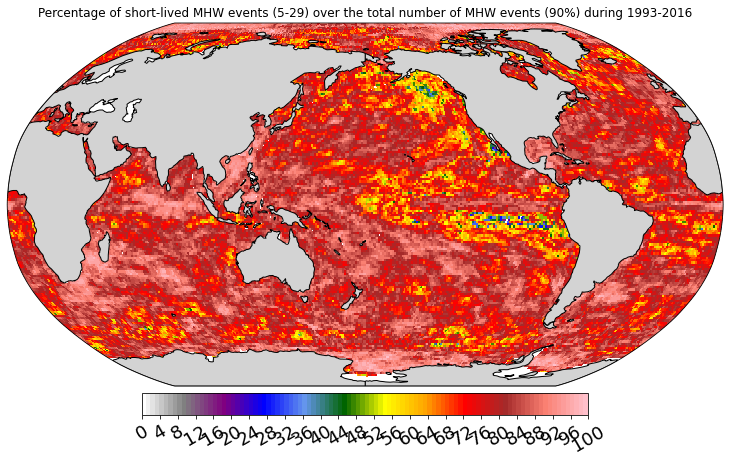

In [43]:
plot_map_from_gridded(event_number_5_30[0], event_number_5_30[1], events_ratio, key, year_start_4plot, year_end_4plot, save_path, stat_tag,
                                dataset_tag, lev_or_int, MHW_duration_threshold_tag, 
                                delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, daily_monthly_plot_tag)


In [42]:
# Main function to create plots - used by heat budget terms, duration, intensity and number - NOT USED FOR CONTRIBUTOR AND +/-   
def plot_map_from_gridded(grid_x, grid_y, grid_z0, keyplot, year_start, year_end, save_path, stat_tag, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, daily_monthly_plot_tag):

    #__________
    # Set color bar details based on specific type of plot and/or variable being plotted
    #__________    
    # Determine vmax as the maximum absolute value
    if stat_tag in ['3rd_contributor', '1st_contributor', '2nd_contributor', 'positive_negative']: # for the plots for main contributor (and %)
        vmin = 0
        vmax = 100
        cmap = plt.get_cmap('hot_r')  # You can choose any other colormap
        levels = np.linspace(vmin, vmax, vmax-vmin+1)
        levels_cbar = levels[::5]
    elif stat_tag == 'Mean_difference_onset_MINUS_decline':
        if 'data_used4MHWs' in keyplot:
            vmin = -20
            white_threshold = 0.1
        elif 'duration_in_tsteps' in keyplot:
            vmin = -100
            white_threshold = 1
        else:    
            vmin = -4E-5
            white_threshold = 1E-8
        vmax = -vmin
        levels = np.linspace(vmin, vmax, 20).tolist()
        # Find the index where the sign changes in the levels list
        index_sign_change = next((i for i, (a, b) in enumerate(zip(levels, levels[1:])) if a * b < 0), None)
        # Insert -1E-8 and 1E-8 at the index where the sign changes
        if index_sign_change is not None:
            levels.insert(index_sign_change + 1, -white_threshold)
            levels.insert(index_sign_change + 2, white_threshold)
        levels = np.array(levels)
#         levels_cbar = levels[::2]
        levels_cbar = levels[[0, *range(3, len(levels) - 1, 3), len(levels) - 1]]#levels[::2]
        cmap = plt.get_cmap('seismic')
    elif keyplot in ['G_advection_eventAve', 'G_advection_onsetAve', 'G_advection_declineAve',\
                    'G_total_eventAve', 'G_total_onsetAve', 'G_total_declineAve', \
                     'G_diffusion_eventAve', 'G_diffusion_onsetAve', 'G_diffusion_declineAve', \
                     'G_forcing_eventAve', 'G_forcing_onsetAve', 'G_forcing_declineAve', \
                     'adv_vConv_eventAve', 'adv_vConv_onsetAve', 'adv_vConv_declineAve', \
                     'dif_vConv_eventAve', 'dif_vConv_onsetAve', 'dif_vConv_declineAve', \
                     'G_advection_conv_eventAve', 'G_advection_conv_onsetAve', 'G_advection_conv_declineAve', \
                     'G_diffusion_conv_eventAve', 'G_diffusion_conv_onsetAve', 'G_diffusion_conv_declineAve']:#these are for monthly - with _conv
        if lev_or_int == 'zlev00':
            vmax = 1E-6 
            vmin = -vmax
            cmap = plt.get_cmap('seismic') #Spectral bwr
            levels = np.linspace(vmin, vmax, 20)
            levels_cbar = levels[::2]
        elif lev_or_int == 'zlev01': # MONTHLY
            if ecco_monthly_tag_field == 'ohc_to50m':
#                 levels = []
#                 levels.append(-2E-5)
#                 levels.append(-1E-5)
#                 levels[2::] = np.linspace(-.5E-5, .5E-5, 30).tolist()
#                 levels.append(1E-5)
#                 levels.append(2E-5)
                vmin = -2E-5
                vmax = 2E-5
                levels = np.linspace (vmin, vmax, 21)
                levels = np.array(levels)
                levels_cbar = levels[::2]
                cmap = plt.get_cmap('seismic')
            else:                 
#                 levels = []
#                 levels.append(-9E-7)
#                 levels.append(-8E-7)
#                 levels[2::] = np.linspace(-7.5E-7, 7.5E-7, 30).tolist()
#                 levels.append(8E-7)
#                 levels.append(9E-7)
#                 levels = np.array(levels)
#                 levels_cbar = levels
#                 cmap = plt.get_cmap('seismic') 
                vmin = -9E-7
                vmax = 9E-7
                levels = np.linspace (vmin, vmax, 21)
                levels = np.array(levels)
                levels_cbar = levels[::2]
                cmap = plt.get_cmap('seismic')
        elif lev_or_int == 'zlev05':
            vmax = 5E-7
            vmin = -vmax
            cmap = plt.get_cmap('bwr')
            levels = np.linspace(vmin, vmax, 20)
            levels_cbar = levels
        elif lev_or_int == 'zlev09':
            vmax = 2E-7
            vmin = -vmax
            cmap = plt.get_cmap('bwr')
            levels = np.linspace(vmin, vmax, 20)
            levels_cbar = levels
        elif lev_or_int == 'ohc_k0_k5': 
##################################################################################################################            
            vmax = 2E-5
            vmin = -vmax
            levels = np.linspace(vmin, vmax, 20).tolist()
#             levels = np.round(levels, 6)
            # Find the index where the sign changes in the levels list
            index_sign_change = next((i for i, (a, b) in enumerate(zip(levels, levels[1:])) if a * b < 0), None)
            # Insert -1E-8 and 1E-8 at the index where the sign changes
            if index_sign_change is not None:
                levels.insert(index_sign_change + 1, -1E-8)
                levels.insert(index_sign_change + 2, 1E-8)
            levels = np.array(levels)
            levels_cbar = levels[[0, *range(3, len(levels) - 1, 3), len(levels) - 1]]#levels[::2]
            cmap = plt.get_cmap('seismic')
#             norm = mpl.colors.Normalize(min(levels), max(levels), clip=False)
#             cmap = cm.seismic
#             levels.append(-2E-5)
#             levels.append(-1E-5)
#             levels[2::] = np.linspace(-.5E-5, .5E-5, 30).tolist()
#             levels.append(1E-5)
#             levels.append(2E-5)
#             levels = np.array(levels)
#             levels_positive = np.logspace(np.log10(1E-7), np.log10(1E-4), num = 20)
#             levels_negatives = -levels_positive[::-1]
#             levels_cbar = np.sort(np.concatenate((levels_negatives, levels_positive)))
#             levels = levels_cbar

##################################################################################################################
# for OSM2024
#             cmap = custom_cmap #plt.get_cmap('seismic')
#             vmax = 2E-5
#             vmin = -vmax
#             levels = np.linspace(vmin, vmax, 31)
#             levels_cbar = levels
    elif keyplot in ['data_used4MHWs_eventAve', 'data_used4MHWs_onsetAve', 'data_used4MHWs_declineAve']:
        if lev_or_int == 'ohc_k0_k5':
            vmax = 6E8 #60
        elif lev_or_int == 'argo':
            vmax = 6E8
        elif ecco_monthly_tag_field == 'ohc_to50m':
            vmax = 6E8
        else: # ECCO at single levels, Argo, OISST
            vmax = 5
        vmin = 0
        cmap = plt.get_cmap('Reds')
        levels = np.linspace(vmin, vmax, 31)
        levels_cbar = levels[::3]
    elif keyplot in ['events_duration_in_tsteps','onset_duration_in_tsteps', 'decline_duration_in_tsteps']:
        if lev_or_int == 'argo' or lev_or_int =='oisst' or \
        daily_monthly_plot_tag == 'monthly' or '30' in MHW_duration_threshold_tag:
            vmax = 8
            vmin = 0
            levels = np.linspace(vmin, vmax, vmax-vmin+1)
            levels_cbar = levels[::1] 
        elif '5' in MHW_duration_threshold_tag:
            vmax = 30
            vmin = 0
            levels = np.linspace(vmin, vmax, vmax-vmin+1)
            levels_cbar = levels[::10]   
        else:
            vmax = 200
            vmin = 0
            levels = np.linspace(vmin, vmax, np.int((vmax-vmin+4)/5*2))
            levels_cbar = levels[::20] 
#         cmap = plt.get_cmap('hot_r')
        cmap_name = 'many_cols'
        cmap_cols = [mcolors.to_rgba('white'),
                     mcolors.to_rgba('gray'),
                     mcolors.to_rgba('purple'),
                     mcolors.to_rgba('blue'),
                     mcolors.to_rgba('cornflowerblue'),
#                      mcolors.to_rgba('mediumseagreen'),
                     mcolors.to_rgba('darkgreen'),
                     mcolors.to_rgba('yellow'),
                     mcolors.to_rgba('orange'),
                     mcolors.to_rgba('red'),
                     mcolors.to_rgba('brown'),
                     mcolors.to_rgba('salmon'),
                     mcolors.to_rgba('pink'),
                    ]
        cmap_custom = LinearSegmentedColormap.from_list(cmap_name, cmap_cols, N=80)
        cmap = cmap_custom
        
    elif keyplot in ['events_number']:
        vmin = 0
        cmap_name = 'many_cols'
        cmap_cols = [mcolors.to_rgba('white'),
                     mcolors.to_rgba('gray'),
                     mcolors.to_rgba('purple'),
                     mcolors.to_rgba('blue'),
                     mcolors.to_rgba('cornflowerblue'),
#                      mcolors.to_rgba('mediumseagreen'),
                     mcolors.to_rgba('darkgreen'),
                     mcolors.to_rgba('yellow'),
                     mcolors.to_rgba('orange'),
                     mcolors.to_rgba('red'),
                     mcolors.to_rgba('brown'),
                     mcolors.to_rgba('salmon'),
                     mcolors.to_rgba('pink'),
                    ]
        cmap_custom = LinearSegmentedColormap.from_list(cmap_name, cmap_cols, N=100)
        cmap = cmap_custom
        if lev_or_int == 'argo' or lev_or_int =='oisst' or daily_monthly_plot_tag == 'monthly':
            vmax = 52#40
            levels = np.linspace(vmin, vmax, np.int((vmax-vmin+1)))#np.int((vmax-vmin+2)/2))
            levels_cbar = levels[::4]  
        else:
            vmax = 100 #40
            levels = np.linspace(vmin, vmax, np.int((vmax-vmin+1)))
            levels_cbar = levels[::4]
            
    # Set other tags needed for the title of the map
    if 'onset' in keyplot:
        titletag = 'onset'
        value_tag = 'positive'
    elif 'decline' in keyplot:
        titletag = 'decline'
        value_tag = 'negative'
    else:
        titletag = 'events'
        
    common_name = remove_text_after_second_underscore(keyplot)
    
    #__________
    # Make plot
    #__________  
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-180))
    norm = mcolors.BoundaryNorm(levels, cmap.N)
#     norm = colors.SymLogNorm(linthresh=1E-7, linscale=1E-15, vmin=min(levels), vmax=max(levels)) #,mcolors.BoundaryNorm(levels, cmap.N)
#     norm = mpl.colors.TwoSlopeNorm(vmin=-3E-5, vcenter=0, vmax=3E-5)
#     norm = mpl.colors.Normalize(vmin=-3E-5, vmax=3E-5, clip=False)

    extend_cbar_tag = get_colorbar_extend(grid_z0, vmin, vmax)
    
    im = ax.pcolormesh(grid_x.T, grid_y.T, grid_z0, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())       
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey', zorder=1)
    cbar = fig.colorbar(im, ax=ax, ticks=levels_cbar, boundaries=levels, pad=.015, orientation="horizontal", shrink=.4, extend=extend_cbar_tag)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.xaxis.offsetText.set_fontsize(14)
    cbar.ax.tick_params(rotation=30)


    # Title varies based on type of plot 
    plt.title(f'Percentage of short-lived MHW events (5-29) over the total number of MHW events (90%) during {year_start}-{year_end}')
    
    # specific case for tests with the code that has the peaks in the onset phase
    save_name = f'{dataset_tag}_{lev_or_int}_{daily_monthly_plot_tag}_{year_start}_{year_end}_prcnt90_noTrend_minLen{MHW_duration_threshold_tag}_EVENTS_RATIO_{stat_tag}.png'

    print(save_name)
    plt.savefig(save_path + str(year_start) + '_' + str(year_end) + '/' + save_name, dpi=300, facecolor='white', edgecolor='none', bbox_inches='tight')  # Save the figure

    plt.show()
    return